In [1]:
from data_preprocessing.DataLoader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import calendar

In [2]:
d = DataLoader.load_data_from_path("data")

In [3]:
products = d.products

In [4]:
# Splitting category_path into smaller categories, so it can be easier to group them and analyze each category separately

categories = products.category_path.str.split(';', expand=True)
products = pd.concat([products, categories], axis=1)
products = products.drop(columns=['category_path'])
products = products.rename(columns= {0: "primary_category", 1 :"secondary_category", 2 : "tertiary_category", 3 : "quaternary_category"})
products['price'] = products['price'].abs()

In [5]:
products.dtypes

product_id               int64
product_name            object
price                  float64
primary_category        object
secondary_category      object
tertiary_category       object
quaternary_category     object
dtype: object

In [6]:
products.describe()

,product_id,price
count,319.000000,3.190000e+02
mean,1160.000000,4.326200e+06
std,92.231593,4.010396e+07
min,1001.000000,1.000000e+00
25%,1080.500000,2.644500e+01
50%,1160.000000,4.999000e+01
75%,1239.500000,1.189500e+02
max,1319.000000,6.887800e+08


In [7]:
deliveries = d.deliveries

In [8]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-16 22:56:36,2021-02-21 00:39:10.536911,360.0
1,20002,2021-02-24 00:56:14,2021-02-27 14:05:55.281323,360.0
2,20003,2021-03-15 03:08:10,NaT,620.0
3,20004,2021-03-10 21:08:11,NaT,516.0
4,20005,2021-01-04 08:12:08,2021-01-03 05:46:20.558336,620.0
...,...,...,...,...
7035,27036,2021-01-13 23:58:40,2021-01-18 11:55:22.010087,516.0
7036,27037,2021-01-14 03:48:43,2021-01-16 15:59:29.566011,620.0
7037,27038,2021-02-25 12:52:33,2021-02-26 01:49:17.857426,516.0
7038,27039,2021-01-07 15:36:47,2021-01-05 12:16:35.844528,360.0


In [9]:
deliveries.dtypes

purchase_id                    int64
purchase_timestamp    datetime64[ns]
delivery_timestamp    datetime64[ns]
delivery_company             float64
dtype: object

In [10]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-16 22:56:36,2021-02-21 00:39:10.536911,360.0
1,20002,2021-02-24 00:56:14,2021-02-27 14:05:55.281323,360.0
2,20003,2021-03-15 03:08:10,NaT,620.0
3,20004,2021-03-10 21:08:11,NaT,516.0
4,20005,2021-01-04 08:12:08,2021-01-03 05:46:20.558336,620.0
...,...,...,...,...
7035,27036,2021-01-13 23:58:40,2021-01-18 11:55:22.010087,516.0
7036,27037,2021-01-14 03:48:43,2021-01-16 15:59:29.566011,620.0
7037,27038,2021-02-25 12:52:33,2021-02-26 01:49:17.857426,516.0
7038,27039,2021-01-07 15:36:47,2021-01-05 12:16:35.844528,360.0


In [11]:
deliveries.loc[deliveries["delivery_company"].isnull(),["delivery_company"]] = "Empty"
# deliveries["delivery_company"].isnull()="Empty"

In [12]:
print(deliveries.to_string())

      purchase_id  purchase_timestamp         delivery_timestamp delivery_company
0           20001 2021-02-16 22:56:36 2021-02-21 00:39:10.536911              360
1           20002 2021-02-24 00:56:14 2021-02-27 14:05:55.281323              360
2           20003 2021-03-15 03:08:10                        NaT              620
3           20004 2021-03-10 21:08:11                        NaT              516
4           20005 2021-01-04 08:12:08 2021-01-03 05:46:20.558336              620
5           20006 2021-01-10 03:05:54 2021-01-13 21:50:34.044368              620
6           20007 2021-01-13 20:55:30 2021-01-14 05:44:08.427193              360
7           20008 2021-01-12 20:55:47 2021-01-15 06:30:08.701909            Empty
8           20009 2021-01-29 10:43:12 2021-01-29 19:27:12.399014              516
9           20010 2021-01-01 01:04:21 2020-12-31 23:45:27.977783              620
10          20011 2021-02-22 12:26:57 2021-02-24 01:00:01.279470              516
11          2001

In [13]:
#count difference between ordering and delivering
deltas =  deliveries.delivery_timestamp - deliveries.purchase_timestamp 

In [14]:
#get rid of None values
deltas_clean = deltas.dropna()

In [15]:
deltas_clean

0        4 days 01:42:34.536911
1        3 days 13:09:41.281323
4      -2 days +21:34:12.558336
5        3 days 18:44:40.044368
6        0 days 08:48:38.427193
                 ...           
7035     4 days 11:56:42.010087
7036     2 days 12:10:46.566011
7037     0 days 12:56:44.857426
7038   -3 days +20:39:48.844528
7039   -1 days +15:20:47.532694
Length: 6672, dtype: timedelta64[ns]

In [16]:
#take absolute values from cleand data deltas
deltas_clean_abs = deltas_clean.abs()

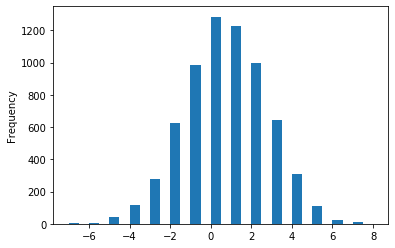

In [17]:
#delivery time without absolute values
deltas_clean.astype('timedelta64[D]').plot.hist(bins = 30)

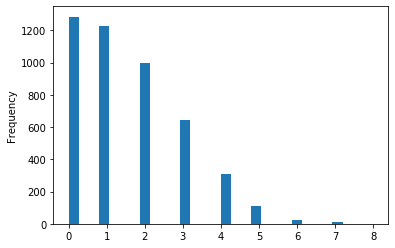

In [18]:
#delivery time without negative values
deltas_clean[deltas_clean>= pd.Timedelta(0)].astype('timedelta64[D]').plot.hist(bins = 30)

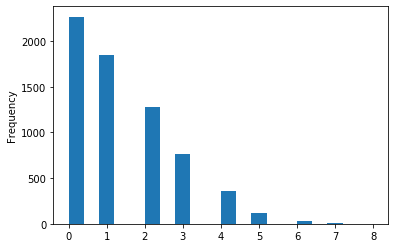

In [19]:
#delivery time with absolute values
deltas_clean_abs.astype('timedelta64[D]').plot.hist(bins = 20)

In [20]:
deliveries["deltas"] = deltas.astype('timedelta64[D]')

In [21]:
deliveries_clean = deliveries.dropna()

In [22]:
import numpy as np

In [23]:
#mean and standard variation of each company's delivery duration
deliveries_clean.groupby("delivery_company")["deltas"].agg([np.mean,np.std])

,mean,std
delivery_company,,
360.0,0.485053,2.072962
516.0,0.528329,2.051740
620.0,0.506548,2.009850
Empty,0.500000,2.035967


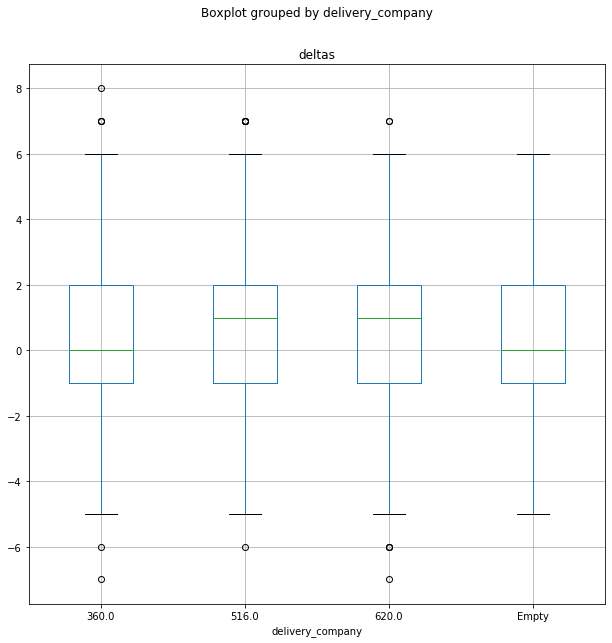

In [24]:
deliveries_clean.boxplot(column="deltas",by='delivery_company',figsize=(10,10))

In [25]:
deliveries.describe()

,purchase_id,deltas
count,7040.00000,6672.000000
mean,23520.50000,0.506445
std,2032.41728,2.043879
min,20001.00000,-7.000000
25%,21760.75000,-1.000000
50%,23520.50000,0.000000
75%,25280.25000,2.000000
max,27040.00000,8.000000


Text(0, 0.5, 'User count')

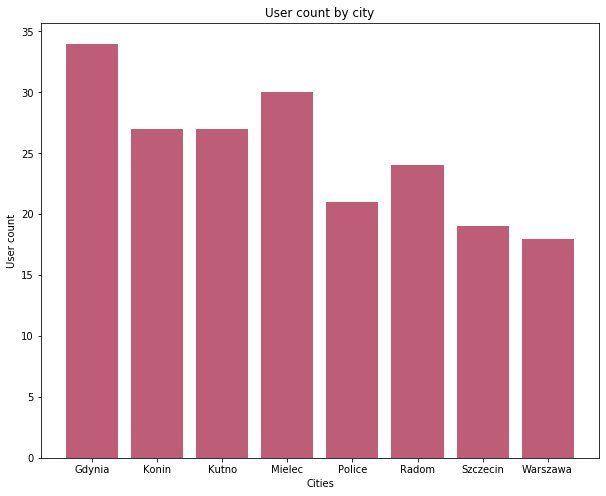

In [26]:
# Client location analysis - knowing where clients live is crucial to estimate delivery time
# The smaller the city is, the delivery time gets longer
cityCount = d.users.groupby('city', as_index=False).user_id.count()
plt.figure(figsize=(10, 8))
plt.bar(cityCount.city, cityCount.user_id, color='#BE5D77')
plt.title("User count by city")
plt.xlabel("Cities")
plt.ylabel("User count")

In [27]:
# Joining dataframes to further use in other plots
# We want to check whether there is a relationship between cities and delivery time.
deliveries_ses_user = deliveries_clean.merge(d.sessions[['user_id', 'purchase_id', 'product_id']], on='purchase_id')
deliveries_ses_user = deliveries_ses_user.merge(d.users[['user_id','city']], on='user_id')

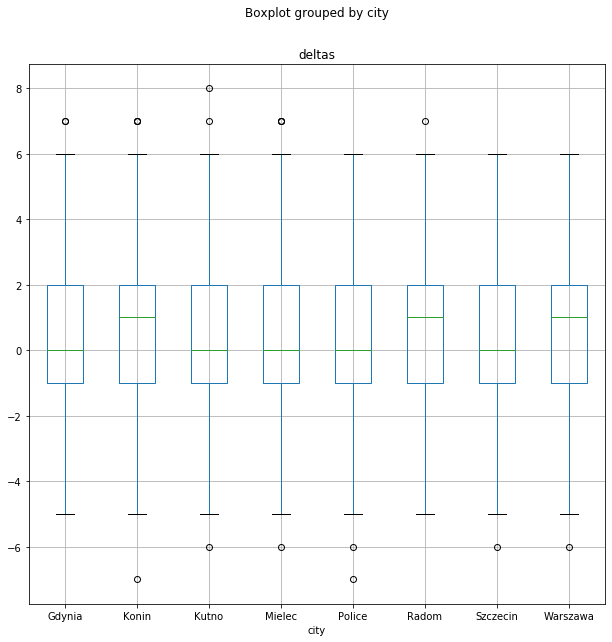

In [28]:
deliveries_ses_user.boxplot(column="deltas",by='city',figsize=(10,10))

Text(0, 0.5, 'Deliveries mean')

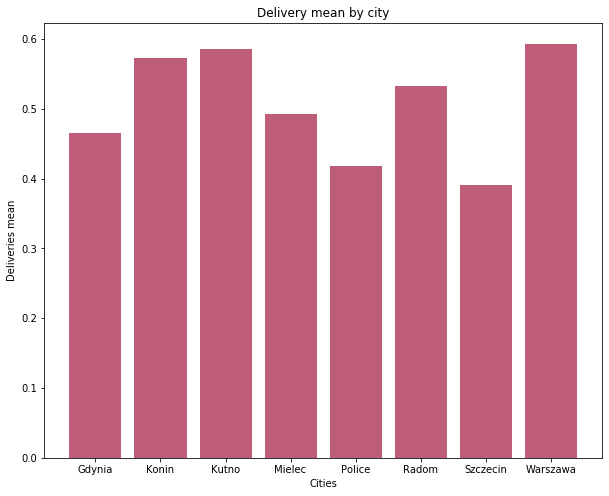

In [29]:
# Turned out boxplots weren't helpful so we check the mean for each city
deliveries_city = deliveries_ses_user.groupby('city', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_city.city, deliveries_city.deltas, color='#BE5D77')
plt.title("Delivery mean by city")
plt.xlabel("Cities")
plt.ylabel("Deliveries mean")

In [30]:
#Joining products dataframe to check the relationship between delivery time and product category.
deliveries_ses_user_prod = deliveries_ses_user.merge(products, on='product_id')


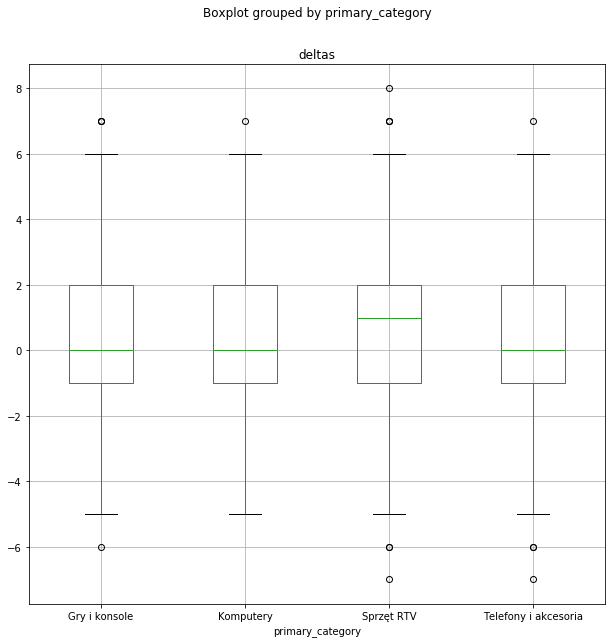

In [31]:
deliveries_ses_user_prod.boxplot(column="deltas",by='primary_category',figsize=(10,10))

Text(0, 0.5, 'Deliveries mean')

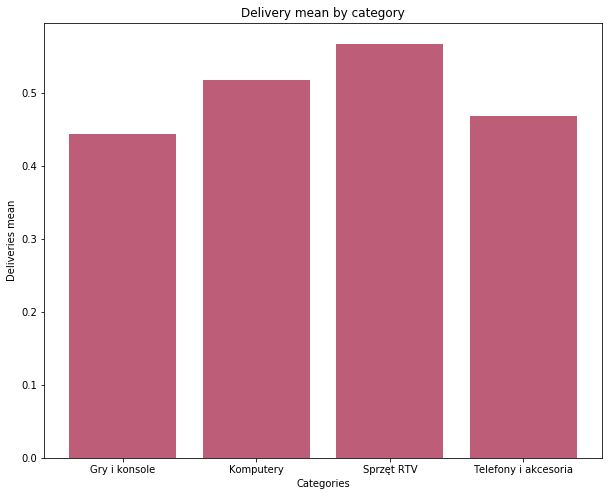

In [32]:
#Checking the mean for categories as well
deliveries_category = deliveries_ses_user_prod.groupby('primary_category', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_category.primary_category, deliveries_category.deltas, color='#BE5D77')
plt.title("Delivery mean by category")
plt.xlabel("Categories")
plt.ylabel("Deliveries mean")

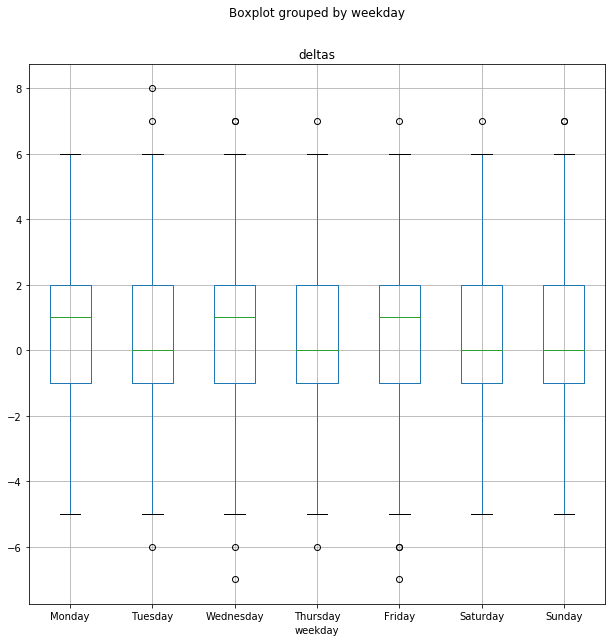

In [33]:
#Adding new column with day of the week and checking its relationship with delivery time
deliveries_ses_user_prod['weekday'] = deliveries_ses_user_prod['purchase_timestamp'].dt.day_name()
deliveries_ses_user_prod.boxplot(column="deltas",by='weekday',figsize=(10,10), positions=[4,0,5,6,3,1,2])


Text(0, 0.5, 'Deliveries mean')

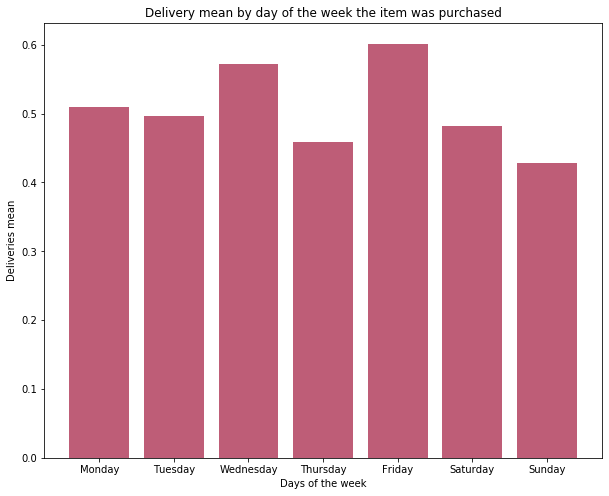

In [34]:
# No simple way to reorder the bars in matplotlib, so we had to use this trick
# We create an artificial key, by which we will sort dataframe
work_df = deliveries_ses_user_prod
work_df = work_df.groupby('weekday').deltas.mean().reset_index()
work_df = work_df.reindex([1,5,6,4,0,2,3])
plt.figure(figsize=(10, 8))

plt.bar(work_df.weekday, work_df.deltas, color='#BE5D77')
plt.title("Delivery mean by day of the week the item was purchased")
plt.xlabel("Days of the week")
plt.ylabel("Deliveries mean")

In [35]:
#Function for labeling rows
def labelTimeOfDay(row):
    hour = row['purchase_timestamp'].hour
    if(hour >= 6 and hour < 12):
        return "Morning"
    elif(hour >= 12 and hour < 18):
        return "Afternoon"
    elif(hour >=18 and hour < 24):
        return "Evening"
    else:
        return "Night"

In [36]:
#Using the function above to label all the rows
deliveries_clean.loc[:,'time_of_day'] = deliveries_clean.apply(lambda row: labelTimeOfDay(row), axis=1)

/home/zuznanna/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/zuznanna/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


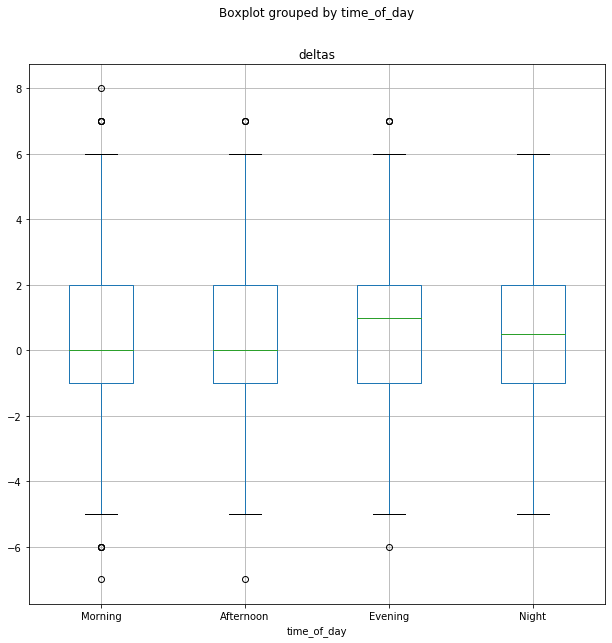

In [37]:
#Checking the relationship between the time of the day when we purchased the item and its delivery time
deliveries_clean.boxplot(column="deltas",by='time_of_day',figsize=(10,10), positions=[1,2,0,3])

Text(0, 0.5, 'Deliveries mean')

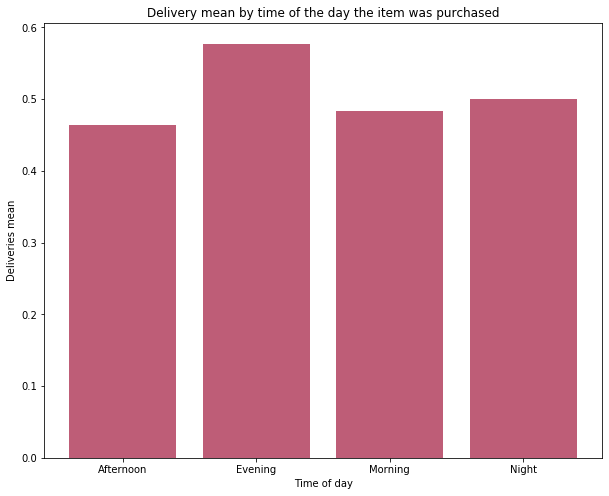

In [38]:
# Once again checking the mean for other clues
deliveries_clean = deliveries_clean.groupby('time_of_day', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_clean.time_of_day, deliveries_clean.deltas, color='#BE5D77')
plt.title("Delivery mean by time of the day the item was purchased")
plt.xlabel("Time of day")
plt.ylabel("Deliveries mean")

In [39]:
# Investigating negative values of delta column 
deliveries_ses_user_prod_neg = deliveries_ses_user_prod[deliveries_ses_user_prod['deltas'] < 0]

In [40]:
deliveries_ses_user_prod

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,deltas,user_id,product_id,city,product_name,price,primary_category,secondary_category,tertiary_category,quaternary_category,weekday
0,20001,2021-02-16 22:56:36,2021-02-21 00:39:10.536911,360,4.0,102.0,1222.0,Kutno,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Tuesday
1,20033,2021-03-11 10:57:49,2021-03-09 08:32:30.845717,516,-3.0,102.0,1222.0,Kutno,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Thursday
2,20091,2021-01-19 15:28:12,2021-01-18 00:29:06.809978,620,-2.0,103.0,1222.0,Mielec,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Tuesday
3,20105,2021-01-28 13:18:51,2021-02-02 06:34:52.671013,360,4.0,103.0,1222.0,Mielec,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Thursday
4,20181,2021-01-11 13:21:20,2021-01-11 17:17:43.827780,360,0.0,108.0,1222.0,Gdynia,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,25490,2021-03-10 21:26:02,2021-03-10 14:44:11.702221,620,-1.0,258.0,1040.0,Police,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Wednesday
6012,25652,2021-01-21 12:04:38,2021-01-22 11:35:27.371368,620,0.0,263.0,1040.0,Mielec,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Thursday
6013,25743,2021-03-14 17:50:14,2021-03-20 01:09:03.828943,516,5.0,265.0,1040.0,Police,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Sunday
6014,25762,2021-02-05 02:21:59,2021-02-05 18:01:23.276859,360,0.0,266.0,1040.0,Mielec,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Friday


In [41]:
# Rows with negative values represent around 31% of the whole dataset 
percent = len(deliveries_ses_user_prod_neg.index)/len(deliveries_ses_user_prod.index)
print(round(percent,2))

0.31


In [42]:
# Analyzing the problem of NaT values in timestamps columns in deliveries dataframe
deliveries = d.deliveries
deliveries_empty = deliveries[deliveries.purchase_timestamp.isnull() | deliveries.delivery_timestamp.isnull()]
percent = len(deliveries_empty)/len(deliveries)
print(round(percent,2))

0.05


In [43]:
# There is no problem with checking when the item was purchased on the site
print(len(deliveries[deliveries.purchase_timestamp.isnull()]))

0


In [44]:
delivery_empty = deliveries[deliveries.delivery_timestamp.isnull()]
delivery_grouped = deliveries_empty.groupby('delivery_company', as_index=False).purchase_id.count()

Text(0, 0.5, 'Number of empty rows')

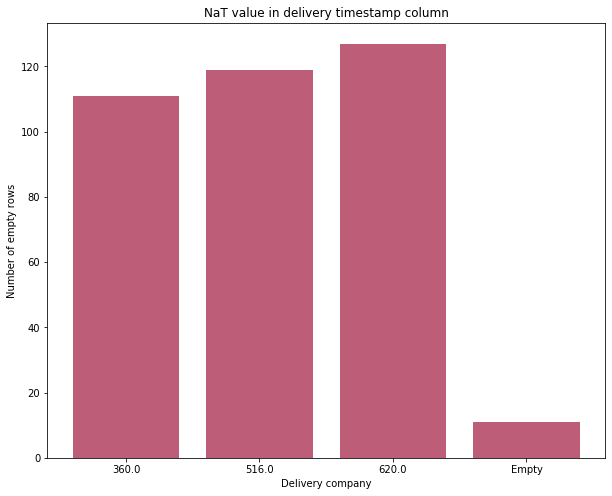

In [47]:
plt.figure(figsize=(10, 8))
plt.bar(delivery_grouped.delivery_company.astype(str), delivery_grouped.purchase_id, color='#BE5D77')
plt.title("NaT value in delivery timestamp column")
plt.xlabel("Delivery company")
plt.ylabel("Number of empty rows")

In [46]:
delivery_empty

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,deltas
2,20003,2021-03-15 03:08:10,NaT,620,NaN
3,20004,2021-03-10 21:08:11,NaT,516,NaN
13,20014,2021-02-02 18:06:14,NaT,620,NaN
51,20052,2021-01-14 20:59:42,NaT,516,NaN
56,20057,2021-02-20 11:51:18,NaT,516,NaN
...,...,...,...,...,...
7014,27015,2021-03-09 17:18:19,NaT,516,NaN
7016,27017,2021-01-21 01:13:51,NaT,516,NaN
7019,27020,2021-01-04 15:54:42,NaT,516,NaN
7025,27026,2021-01-01 23:33:43,NaT,516,NaN


In [ ]:
deliveries = d.deliveries

In [ ]:
deliveries_not_empty_delivery = deliveries[deliveries["delivery_timestamp"].notnull()]

In [ ]:
deliveries_not_empty_delivery

In [ ]:
deliveries_not_empty_delivery[deliveries_not_empty_delivery.isna().any(axis=1)]

In [ ]:
print(deliveries_not_empty_delivery[deliveries_not_empty_delivery.isna().any(axis=1)].to_string())